## Classifying cifar10 images using ResNets,Regularization and data augumentation in pytorch

In [36]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn.functional as F




In [37]:
project_name="cifar10_resnet"

In [38]:
#downloading dataset
dataset_url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,"./data")

In [39]:
with tarfile.open("./data/cifar10.tgz","r:gz") as tar:
    tar.extractall(path="./data")

C:\Users\Srikanth\AppData\Local\Temp\ipykernel_24524\1800157065.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="./data")


In [40]:
data_dir="./data/cifar10"
print(os.listdir(data_dir))
print(os.listdir(data_dir+"/train"))

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


1.Use test set for validation:

Use test set as validation set.In general once you have picked the best model architecture and hyperparameters using a fixed validation set it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance

2.Channel wise data normalization:
Normalizing data prevents the values from any one channel from disproportionately affecting the losses and gradients while training,simply by having a higher or wider range of values that others

3.Randomized data Augumentations:we will apply randomly chosen transformations while loading images from the training dataset.


In [42]:
#data Transformations
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode="reflect"),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize(*stats,inplace=True)]) #simply adding noise to inputs to avoid overfiiting
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [43]:
#pytorch datasets
train_ds=ImageFolder("./data/cifar10/train",train_tfms)
val_ds=ImageFolder("./data/cifar10/test",valid_tfms)


In [44]:
train_dl=DataLoader(train_ds,batch_size=300,shuffle=True,num_workers=3,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=300*2,num_workers=3,pin_memory=True)

In [45]:
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means
def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images=denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break
                            

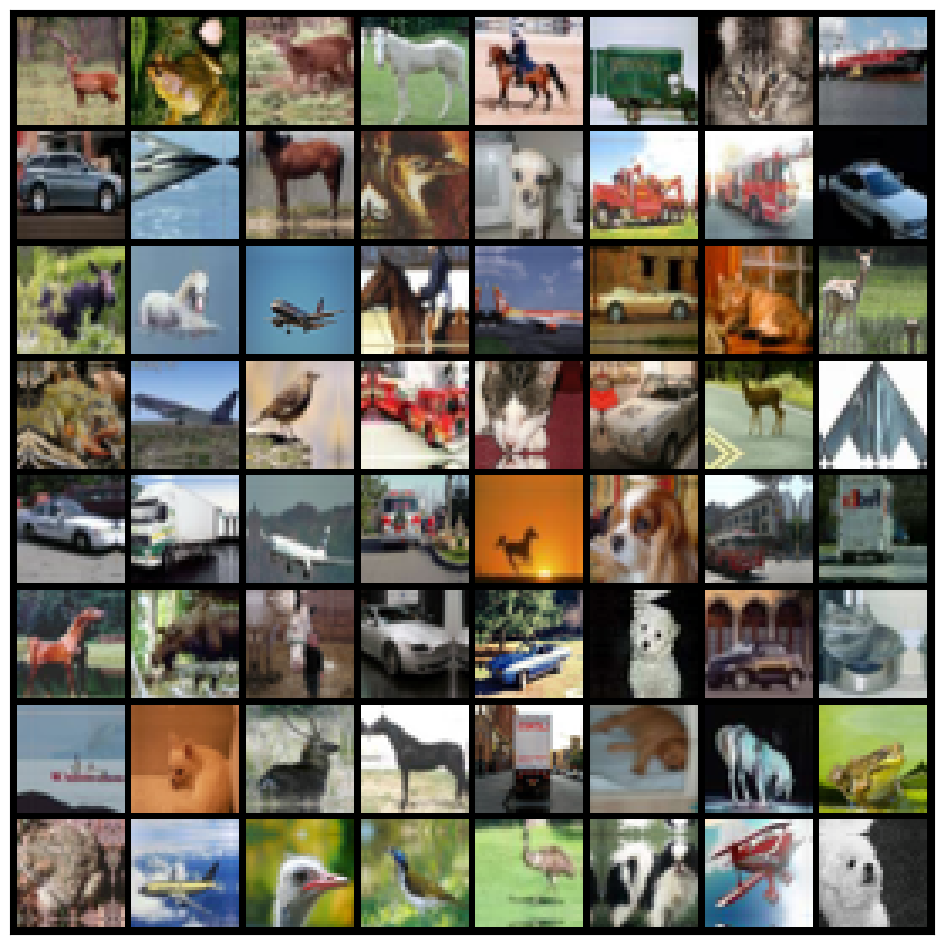

In [46]:
show_batch(train_dl)

## Using a GPU



In [48]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
        

In [49]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
    

In [50]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [51]:
device=get_default_device()
device

device(type='cuda')

In [52]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

## Model with Residual Blocks and Batch Normalization

one of the key changes to our cnn model this time is the addition of the residual block,which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers  
conv layers are responsible to convert input to output without residual layers  
conv layers with residual layers arr responsible to compare input with output  

but we dont change output channels




In [55]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
    def forward(self,x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.conv2(out)
        return self.relu2(out)+x #relu can be applied before or after adding the input

In [56]:
simple_resnet=to_device(SimpleResidualBlock(),device)
for images,labels in train_dl:
    print(images.shape)
    out=simple_resnet(images)
    print(out.shape)
    break
del simple_resnet,images,labels
torch.cuda.empty_cache()

torch.Size([300, 3, 32, 32])
torch.Size([300, 3, 32, 32])


this seeming small change produces a drastic improvement inn the performance of the model  
after each convolutional layer ,add a batch normalization layer ,which normalizes the outputs of the previous layer   

batch norm simply ensures that output of every layer is  normalized,so that no particular channel dominate loss and grdient

<b>refer:towards datascience



###  Constructing Resnet9 architecure

In [59]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"],result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [60]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [61]:
class ResNet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        #3X32X32
        self.conv1=conv_block(in_channels,64)#64X32X32
        self.conv2=conv_block(64,128,pool=True)#128X16X16
        self.res1=nn.Sequential(conv_block(128,128),
                               conv_block(128,128))#128X16X16
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),
                               conv_block(512,512))
        self.classifier=nn.Sequential(nn.MaxPool2d(4), #512X1X1
                                     nn.Flatten(),#512
                                     nn.Dropout(0.2),#to avoid overfitting (randomly pick 20% output and set it to 0)
                                     nn.Linear(512,num_classes)) #10
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out
        
        

In [62]:
model=to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Some other improvements:  
1.Learning rate Scheduling:instead of fixeed lr we use "One Cycle Learning Rate Policy"
which involves startin with low lr ,gradually increaasing it batch by batch to a high lr for about 30% of epochs ,then gradually decresing it to a very low value for the remaining epochs.  
2.weight decay  
3.gradient clipping:to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.  

<b>refer towardsdatascience


In [65]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()  # (for no randamization)some layer behave diff for train and test for ex :batchnorm,dropout we dont require dropout while evaulating
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [66]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [67]:
def fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        #training phase
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # grad clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            #record $update lr
            lrs.append(get_lr(optimizer))
            sched.step() #lr differ for each batch
        #validation phase
        result=evaluate(model,val_dl)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        result["lrs"]=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history
            

In [68]:
history=[evaluate(model,val_dl)]
history

[{'val_loss': 2.3024702072143555, 'val_acc': 0.11764705926179886}]

instead of sgd we will use the adam which uses techniques like momentum and adaptive learning rates for faster training.

In [70]:
epochs=8
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam


<b>refer:ruder.io for optimizers  
stanford don bench competetion

In [72]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss:1.4519 val_loss: 1.5164, val_acc: 0.5164
Epoch [1], train_loss:1.0658 val_loss: 1.3870, val_acc: 0.5968
Epoch [2], train_loss:0.8185 val_loss: 0.6978, val_acc: 0.7565
Epoch [3], train_loss:0.6129 val_loss: 0.6454, val_acc: 0.7770
Epoch [4], train_loss:0.5030 val_loss: 0.5835, val_acc: 0.8001
Epoch [5], train_loss:0.3932 val_loss: 0.4202, val_acc: 0.8554
Epoch [6], train_loss:0.2902 val_loss: 0.3091, val_acc: 0.8948
Epoch [7], train_loss:0.2100 val_loss: 0.2746, val_acc: 0.9078
CPU times: total: 52.9 s
Wall time: 8min 14s


In [73]:
#our model trained to over 90% acc in under 5 min

In [74]:
def plot_accuracies(history):
    acc=[x['val_acc'] for x in history]
    plt.plot(acc,"-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy vs no of epochs")

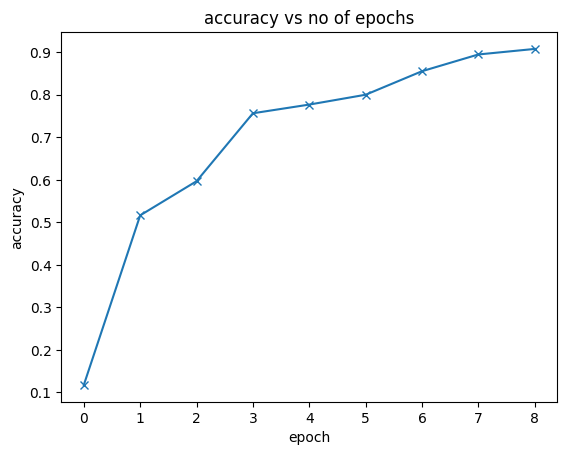

In [75]:
plot_accuracies(history)

In [76]:
def plot_losses(history):
    train_losses=[x["train_loss"] for x in history]
    val_losses=[x["val_loss"] for x in history]
    plt.plot(train_losses,"-bx")
    plt.plot(val_losses,"-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training","Validation"])
    plt.title("loss vs No of epochs")

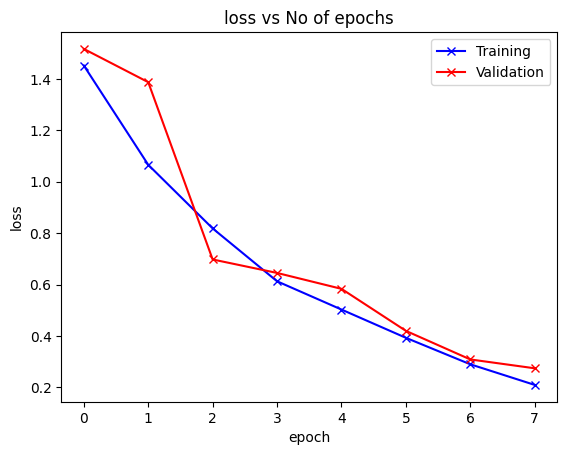

In [84]:
plot_losses(history[1:])

In [86]:
def plot_lrs(history):
    lrs=np.concatenate([x.get("lrs",[]) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch_no")
    plt.ylabel("learning rate")
    plt.title("Learning rate vs batch no")

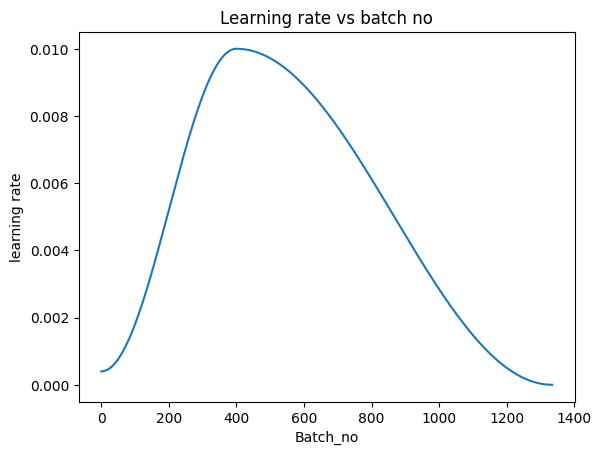

In [90]:
plot_lrs(history[1:])

## Prediction

In [123]:
def predict(model,image):
    image=to_device(image.unsqueeze(0),device)
    out=model(image)
    _,pred=torch.max(out,dim=1)
    
    return train_ds.classes[pred[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.378921..2.734221].


airplane
0


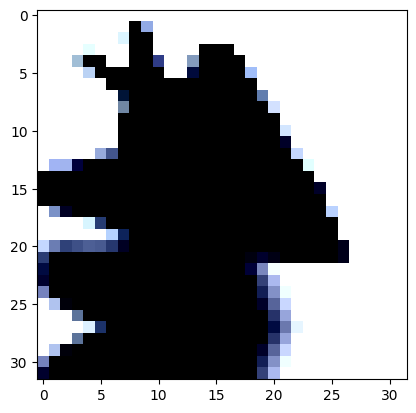

In [125]:
image,label=train_ds[0]
plt.imshow(image.permute(1,2,0))
print(predict(model,image))
print(label)

## Save and Load model

In [130]:
torch.save(model.state_dict(),"cifar10_resnet9.pth")

Data Normalization  
Data augumentation  
Residual connections  
Batch normalization  
Learning RAte Schedular  
weight Decay  
Gradient clipping  
Adam optimizer  

In [ ]:
model2=to_device(ResNet9()